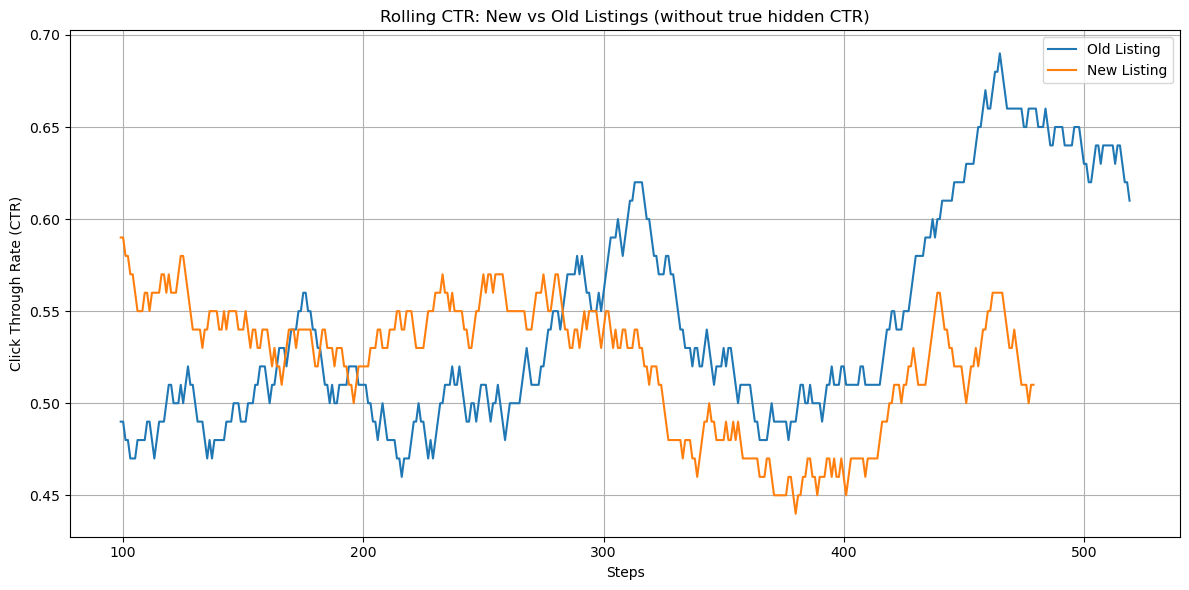

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 设置随机种子
np.random.seed(42)

# 模拟用户和房源
user_groups = ['new', 'returning']
scenes = ['morning', 'evening']
n_users = 200
embedding_dim = 5
n_listings = 10

# 用户表
users = pd.DataFrame({
    'user_id': range(n_users),
    'group': np.random.choice(user_groups, size=n_users, p=[0.4, 0.6]),
    'scene': np.random.choice(scenes, size=n_users, p=[0.5, 0.5]),
    'embedding': [np.random.randn(embedding_dim) for _ in range(n_users)]
})

# 房源表
listings = pd.DataFrame({
    'listing_id': range(n_listings),
    'is_new': [True if i < 3 else False for i in range(n_listings)],
    'embedding': [np.random.randn(embedding_dim) for _ in range(n_listings)],
    'total_click': 0,
    'total_expose': 1,  # 避免除0
})

# 参数设置
group_scene_alpha = {
    ('new', 'morning'): 0.7,
    ('new', 'evening'): 0.5,
    ('returning', 'morning'): 0.3,
    ('returning', 'evening'): 0.1
}

# 初始状态
listing_stats = {
    i: {
        'A': np.identity(embedding_dim * 2),
        'b': np.zeros(embedding_dim * 2),
        'count': 0
    } for i in range(n_listings)
}

# 冷启动bootstrapping设定（前5次强制探索）
bootstrapping_phase = {i: 5 if listings.loc[i, 'is_new'] else 0 for i in range(n_listings)}

# reward记录
rewards_log = []

# 模拟过程
for t in range(1000):
    user = users.sample(1).iloc[0]
    group, scene = user['group'], user['scene']
    alpha = group_scene_alpha[(group, scene)]
    user_emb = user['embedding'] #随机生成的 embedding

    ucb_scores = []
    for i in range(n_listings):
        listing_emb = listings.loc[i, 'embedding']
        x = np.concatenate([user_emb, listing_emb])
        stats = listing_stats[i]
        A_inv = np.linalg.inv(stats['A'])
        theta_hat = A_inv @ stats['b']
        est_ctr = x @ theta_hat
        ucb = est_ctr + alpha * np.sqrt(x @ A_inv @ x)
        ucb_scores.append(ucb)

    # 冷启动处理（强制探索）
    forced_list = [i for i, n in bootstrapping_phase.items() if n > 0]
    if forced_list:
        chosen = np.random.choice(forced_list)
        bootstrapping_phase[chosen] -= 1
    else:
        chosen = int(np.argmax(ucb_scores))

    # 模拟真实点击反馈（用户会点击 embedding 越接近的内容）
    chosen_emb = listings.loc[chosen, 'embedding']
    click_prob = 0.5 + 0.2 * np.tanh(user_emb @ chosen_emb / embedding_dim)
    reward = int(np.random.rand() < click_prob)

    # 更新
    x_chosen = np.concatenate([user_emb, chosen_emb])
    listing_stats[chosen]['A'] += np.outer(x_chosen, x_chosen)
    listing_stats[chosen]['b'] += reward * x_chosen
    listing_stats[chosen]['count'] += 1
    listings.at[chosen, 'total_expose'] += 1
    listings.at[chosen, 'total_click'] += reward

    rewards_log.append({
        'step': t,
        'listing_id': chosen,
        'group': group,
        'scene': scene,
        'is_new': listings.loc[chosen, 'is_new'],
        'reward': reward
    })

# 构建数据框
log_df = pd.DataFrame(rewards_log)
log_df['cumulative_reward'] = log_df['reward'].cumsum()
log_df['ctr'] = log_df['cumulative_reward'] / (log_df.index + 1)

# 滚动CTR
plt.figure(figsize=(12, 6))
for label, df in log_df.groupby('is_new'):
    avg_ctr = df['reward'].rolling(100).mean()
    plt.plot(avg_ctr.reset_index(drop=True), label=f'{"New" if label else "Old"} Listing')

plt.title('Rolling CTR: New vs Old Listings (without true hidden CTR)')
plt.xlabel('Steps')
plt.ylabel('Click Through Rate (CTR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

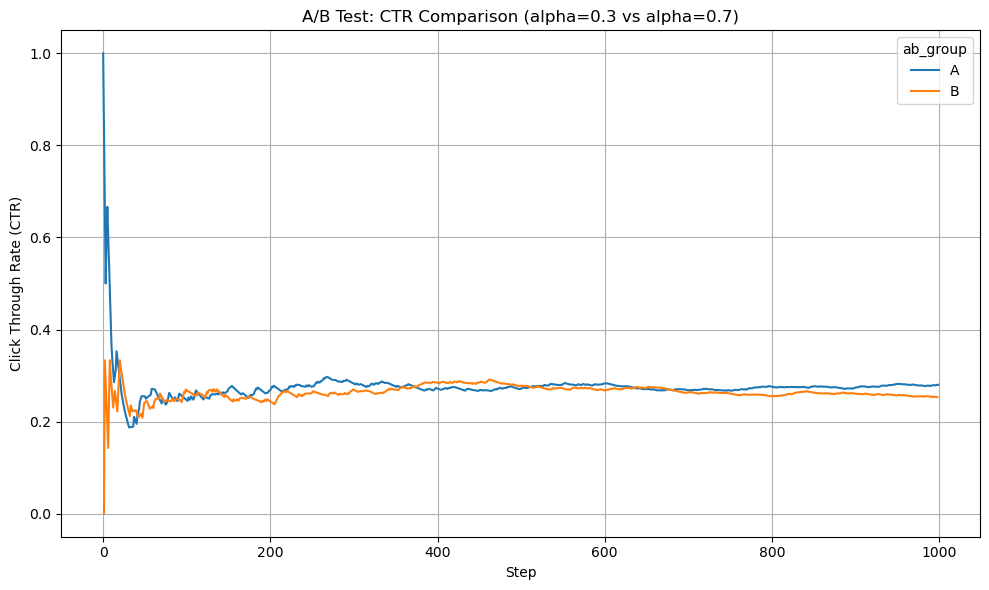

In [2]:
import seaborn as sns

# 设置两个策略的 alpha 值
alpha_group = {
    'A': 0.3,  # 保守探索
    'B': 0.7   # 激进探索
}

# 初始化 reward 日志
ab_rewards_log = []

# 每个用户先随机分配到实验组A或B
users['ab_group'] = np.random.choice(['A', 'B'], size=n_users, p=[0.5, 0.5])

# 初始化 listing 状态（重置）
ab_listing_stats = {
    ab: {
        i: {
            'A': np.identity(embedding_dim * 2),
            'b': np.zeros(embedding_dim * 2),
            'count': 0
        } for i in range(n_listings)
    } for ab in ['A', 'B']
}

# 初始化冷启动探索轮数（两组共享）
ab_bootstrap = {
    i: 5 if listings.loc[i, 'is_new'] else 0
    for i in range(n_listings)
}

# 模拟过程
for t in range(1000):
    user = users.sample(1).iloc[0]
    ab = user['ab_group']
    group, scene = user['group'], user['scene']
    user_emb = user['embedding']
    alpha = alpha_group[ab]
    ucb_scores = []

    for i in range(n_listings):
        listing_emb = listings.loc[i, 'embedding']
        x = np.concatenate([user_emb, listing_emb])
        stats = ab_listing_stats[ab][i]
        A_inv = np.linalg.inv(stats['A'])
        theta_hat = A_inv @ stats['b']
        est_ctr = x @ theta_hat
        ucb = est_ctr + alpha * np.sqrt(x @ A_inv @ x)
        ucb_scores.append(ucb)

    # 强制 bootstrapping
    forced_list = [i for i, n in ab_bootstrap.items() if n > 0]
    if forced_list:
        chosen = np.random.choice(forced_list)
        ab_bootstrap[chosen] -= 1
    else:
        chosen = int(np.argmax(ucb_scores))

    # 模拟点击概率
    chosen_emb = listings.loc[chosen, 'embedding']
    click_prob = 0.5 + 0.2 * np.tanh(user_emb @ chosen_emb / embedding_dim)
    reward = int(np.random.rand() < click_prob)

    # 更新状态
    x_chosen = np.concatenate([user_emb, chosen_emb])
    ab_listing_stats[ab][chosen]['A'] += np.outer(x_chosen, x_chosen)
    ab_listing_stats[ab][chosen]['b'] += reward * x_chosen
    ab_listing_stats[ab][chosen]['count'] += 1

    ab_rewards_log.append({
        'step': t,
        'ab_group': ab,
        'listing_id': chosen,
        'reward': reward,
        'is_new': listings.loc[chosen, 'is_new']
    })

# 转换为 DataFrame
ab_df = pd.DataFrame(ab_rewards_log)
ab_df['cumulative_reward'] = ab_df.groupby('ab_group')['reward'].cumsum()
ab_df['ctr'] = ab_df.groupby('ab_group')['cumulative_reward'].transform(lambda x: x / (x.index + 1))

# 可视化两组策略的 CTR 曲线
plt.figure(figsize=(10, 6))
sns.lineplot(data=ab_df, x='step', y='ctr', hue='ab_group')
plt.title('A/B Test: CTR Comparison (alpha=0.3 vs alpha=0.7)')
plt.xlabel('Step')
plt.ylabel('Click Through Rate (CTR)')
plt.grid(True)
plt.tight_layout()
plt.show()
